In [1]:
import pandas as pd
import helper
import optuna
from optuna.samplers import TPESampler
import strategy
import json

c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("in_sample.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index("datetime", inplace=True)
df

,tickersymbol,price,quantity,SMA50,SMA20,STD20,UpperBB,LowerBB,Resistance,Support,AvgVolume20
datetime,,,,,,,,,,,
2021-01-15 10:29:00,VN30F2101,1193.8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-15 10:30:00,VN30F2101,1197.7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-15 10:31:00,VN30F2101,1194.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-15 10:32:00,VN30F2101,1194.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-15 10:33:00,VN30F2102,1193.7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30 14:41:00,VN30F2301,1000.2,0.0,1005.032,1002.635,2.548947,1007.732894,997.537106,1008.9,998.9,1034258.30
2022-12-30 14:42:00,VN30F2301,1000.2,0.0,1004.888,1002.345,2.474815,1007.294630,997.395370,1008.9,998.9,924760.10
2022-12-30 14:43:00,VN30F2301,1000.2,0.0,1004.734,1002.070,2.386387,1006.842774,997.297226,1008.9,998.9,777874.50


In [3]:
# Load best parameters from saved JSON
with open("original_params.json", "r") as f:
    saved_trial = json.load(f)

# Extract parameters
params = saved_trial["params"]
initial_balance = 40_000_000  # Can still be custom-defined here

results1 = strategy.strategy(
    df,
    SMA_WINDOW_LENGTH=int(params["sma_window"]),
    TAKE_PROFIT_THRES_MEAN_REVERSION=float(params["tp_mean_rev"]),
    TAKE_PROFIT_THRES_MOMENTUM=float(params["tp_momentum"]),
    CUT_LOSS_THRES_MEAN_REVERSION=float(params["sl_mean_rev"]),
    CUT_LOSS_THRES_MOMENTUM=float(params["sl_momentum"]),
    initial_balance=initial_balance,
)

# Print results
for key, value in results1.items():
    if key != "PnL Over Time":
        print(f"{key}: {value}")

Initial Balance: 40000000
Final Balance: 341921999.99999994
Win Rate: 83.33333333333334
Total Trades: 144
Winning Trades: 120
Losing Trades: 24
Accumulated Return: 7.548049999999998
Sharpe Ratio: 0.013550733578558087
Annualized Sharpe Ratio: 3.5205838556838356
Max Drawdown: -0.1457418178661343


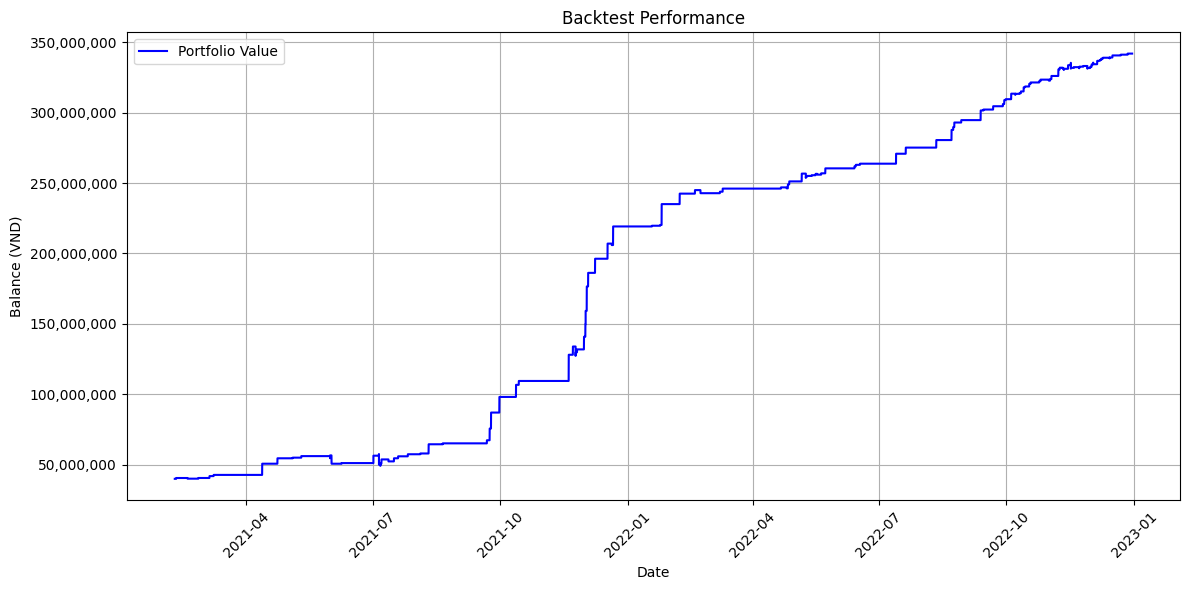

In [4]:
PnL = results1["PnL Over Time"]
date_list = df.index[int(params["sma_window"]) - 1:]  # Align dates with pnl_list length

helper.plot_performance(PnL, date_list)


# Fine tuning

In [8]:
def optuna_objective(trial):
    sma_window = trial.suggest_int("sma_window", 30, 100)
    tp_mean_rev = trial.suggest_float("tp_mean_rev", 3, 10, step=0.5)
    tp_momentum = trial.suggest_float("tp_momentum", 5, 15, step=0.5)
    sl_mean_rev = trial.suggest_float("sl_mean_rev", 3, 10, step=0.5)
    sl_momentum = trial.suggest_float("sl_momentum", 2, 8, step=0.5)

    result = strategy.strategy(
        df,
        SMA_WINDOW_LENGTH=sma_window,
        TAKE_PROFIT_THRES_MEAN_REVERSION=tp_mean_rev,
        TAKE_PROFIT_THRES_MOMENTUM=tp_momentum,
        CUT_LOSS_THRES_MEAN_REVERSION=sl_mean_rev,
        CUT_LOSS_THRES_MOMENTUM=sl_momentum,
        initial_balance = 40_000_000
    )

    return result["Sharpe Ratio"] 


In [9]:
sampler = TPESampler(seed=710)
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(optuna_objective, n_trials=100, show_progress_bar=True)

[I 2025-04-18 03:01:00,300] A new study created in memory with name: no-name-052510e6-483c-45bb-ba57-92279a2993e5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-04-18 03:01:06,202] Trial 0 finished with value: 0.013816343433132757 and parameters: {'sma_window': 90, 'tp_mean_rev': 8.0, 'tp_momentum': 11.5, 'sl_mean_rev': 3.0, 'sl_momentum': 4.0}. Best is trial 0 with value: 0.013816343433132757.
[I 2025-04-18 03:01:12,044] Trial 1 finished with value: 0.014168067507621082 and parameters: {'sma_window': 68, 'tp_mean_rev': 7.0, 'tp_momentum': 14.5, 'sl_mean_rev': 10.0, 'sl_momentum': 7.5}. Best is trial 1 with value: 0.014168067507621082.
[I 2025-04-18 03:01:17,956] Trial 2 finished with value: 0.014081385702699461 and parameters: {'sma_window': 71, 'tp_mean_rev': 7.5, 'tp_momentum': 12.0, 'sl_mean_rev': 4.5, 'sl_momentum': 6.0}. Best is trial 1 with value: 0.014168067507621082.
[I 2025-04-18 03:01:23,932] Trial 3 finished with value: 0.013391643981873157 and parameters: {'sma_window': 96, 'tp_mean_rev': 3.5, 'tp_momentum': 5.5, 'sl_mean_rev': 6.5, 'sl_momentum': 6.5}. Best is trial 1 with value: 0.014168067507621082.
[I 2025-04-18 03:01:

In [10]:
# Print the best parameters set along with the best Sharpe ratio
best_trial = study.best_trial
print("  Value: {}".format(best_trial.value))
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

  Value: 0.014838635780793847
  Params: 
    sma_window: 64
    tp_mean_rev: 10.0
    tp_momentum: 12.0
    sl_mean_rev: 6.5
    sl_momentum: 7.5


In [11]:
# Save best trial info to JSON
best_result = {
    "value": best_trial.value,
    "params": best_trial.params
}

with open("best_trial_result.json", "w") as f:
    json.dump(best_result, f, indent=4)

# Optimized parameters

In [12]:
# Load best parameters from saved JSON
with open("best_trial_result.json", "r") as f:
    saved_trial = json.load(f)

# Extract parameters
params = saved_trial["params"]
initial_balance = 40_000_000  # Can still be custom-defined here

results2 = strategy.strategy(
    df,
    SMA_WINDOW_LENGTH=int(params["sma_window"]),
    TAKE_PROFIT_THRES_MEAN_REVERSION=float(params["tp_mean_rev"]),
    TAKE_PROFIT_THRES_MOMENTUM=float(params["tp_momentum"]),
    CUT_LOSS_THRES_MEAN_REVERSION=float(params["sl_mean_rev"]),
    CUT_LOSS_THRES_MOMENTUM=float(params["sl_momentum"]),
    initial_balance=initial_balance,
)

# Print results
for key, value in results2.items():
    if key != "PnL Over Time":
        print(f"{key}: {value}")


Initial Balance: 40000000
Final Balance: 382343999.99999994
Win Rate: 83.33333333333334
Total Trades: 138
Winning Trades: 115
Losing Trades: 23
Accumulated Return: 8.558599999999998
Sharpe Ratio: 0.014838635780793847
Max Drawdown: -0.13834363411619272


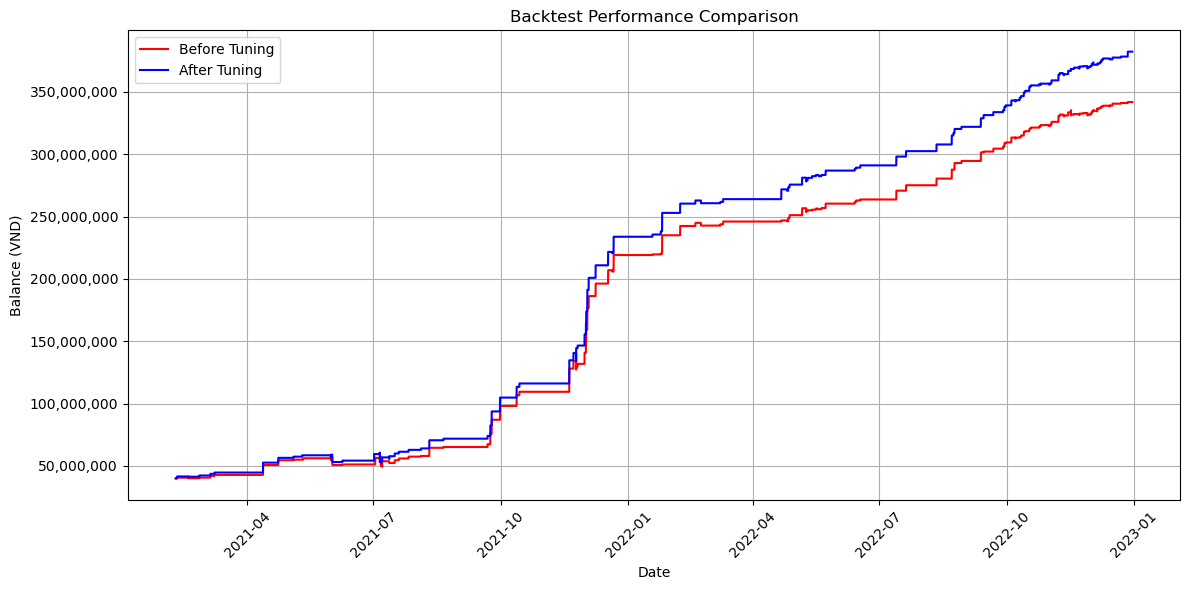

In [13]:
dates = df.index[int(params["sma_window"]) - 1:]
helper.plot_comparison(results1, results2, dates)